# Basic Idea 

This notebook is designed to show a few ways to manipulate decision trees and the early features built onto them.

# Importing Libraries

## Basic Data Tools

In [1]:
import pandas as pd
import numpy as np

## Visulization Tools

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import graphviz

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

## Decision Tree Library

In [3]:
from pynetrees import *
from pynetrees.strategy import *
from pynetrees.render import GraphvizEngine

# Parameters from Exercice

## Insurance Policies

In [4]:
NO_INSURANCE = ("Nothing", 0, lambda x: x)

POLICIES = (
    ("Stayin Alive", 2000, lambda x: 0),
    ("Be Immortal",  1500, lambda x: min(500, x)),
    ("Risk It",      1000, lambda x:.25 * x),
    NO_INSURANCE
)

## Values and Probabilities

In [5]:
LIFE = 200000

P_SICK = .05

LEVELS_PROBS = list(zip((.1, .2, .3), (.5, .4, .1)))

# A Short Tree: How Bad Can You Get Sick (Without Insurance)

## Build the Tree

It would have been faster here to exp,icitly create four transitions and pass them to the event constructor, but I wanted to demonstrate the capacity to build a tree programmatically.

In production usage, simple trees would typically gain from bein built using the constructors, where the textual layout reflects the shape of the tree, along with a few helpers for repetitive patterns.

In [6]:
name, cost, costFunction = NO_INSURANCE

howSick = Event("How Sick")

for l, p in LEVELS_PROBS:
    cost = LIFE * l
    costAfterPolicy = costFunction(cost)
    howSick.transitions.append(
        Transition("{:.0%} loss".format(l),
                   probability=p, payout=-costAfterPolicy))

getSick = Event("Get Sick ?", (
    Transition("Yes", probability=P_SICK, target=howSick),
    Transition("No"),        
))

## Solve

In [7]:
solver = Solver(getSick, createMaxExpected())
solver.solve()

# Visualize the Results

Nodes actually have a function plot() that takes care of this part, and adds some temporary file cleanup.

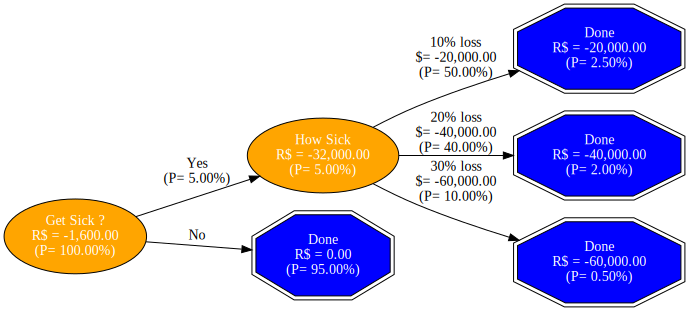

In [8]:
eng = GraphvizEngine(getSick)
graph = eng.render("svg")
graphviz.Source(graph)

# Being sick - Generalized

## Generating the "Being Sick" Pattern

Since the pattern presented above has to be repeated for each policy, it is interesting to create a helper function to generate it, according to each policy.

In [9]:
def fallingSick(policy):
    costFunction = policy[2]

    howSick = Event("How Sick")

    for l, p in LEVELS_PROBS:
        cost = LIFE * l
        costAfterPolicy = costFunction(cost)
        howSick.transitions.append(
            Transition("{:.0%} loss".format(l), 
                       probability=p, payout=-costAfterPolicy))
        
    getSick = Event("Get Sick ?", (
        Transition("Yes", probability=P_SICK, target=howSick),
        Transition("No")))
    
    return getSick

## Creating the Decision Nodes

We iterate through our policy list to create the transition of the policy decision nodes towards the "getting sick" pattern created using the previous function.

In [10]:
whatPolicy = Decision("What Policy ?")
for pol in POLICIES:
    name, cost, costFunction = pol
    whatPolicy.transitions.append(
        Transition(name, -cost, target=fallingSick(pol)))

## Solve

You would normally look at the tree before solving it, I skip this step for brievety.

In [11]:
solver = Solver(whatPolicy, createMaxExpected())
solver.solve()

## Visualize

### Complete

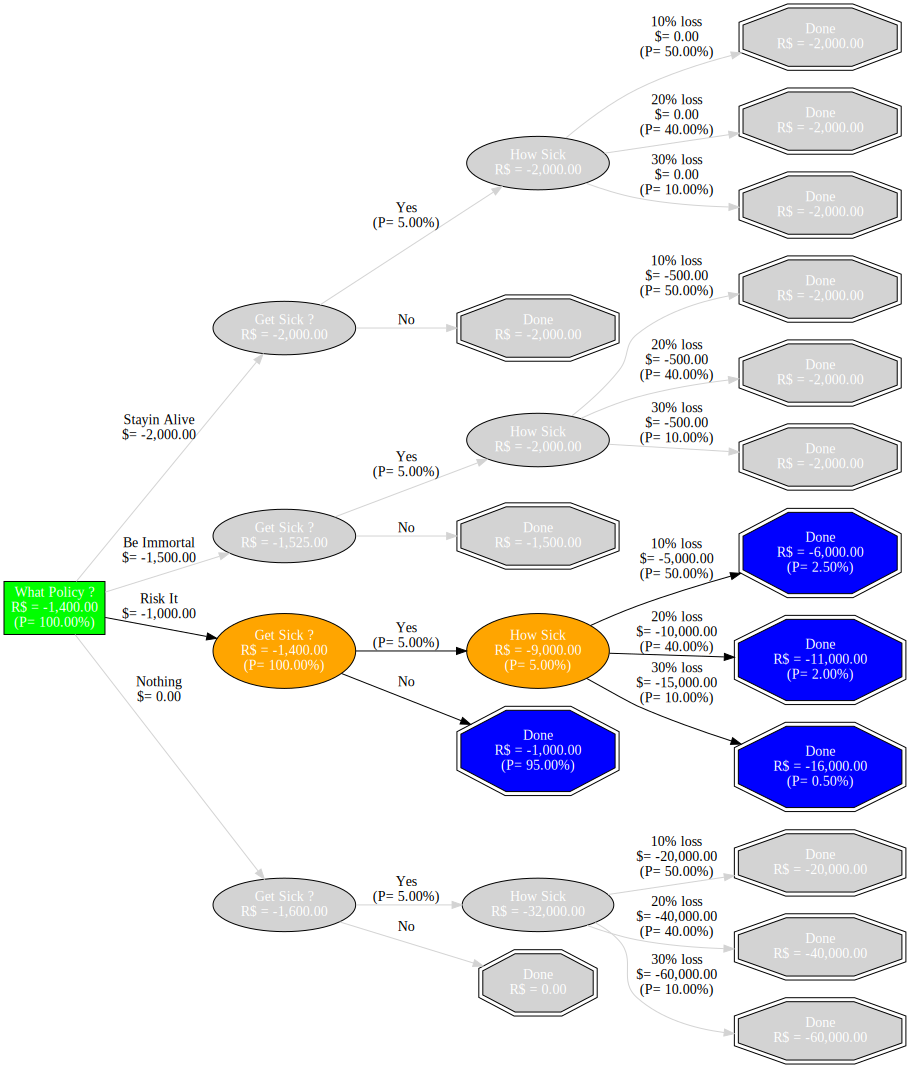

In [12]:
eng = GraphvizEngine(whatPolicy)
graph = eng.render("svg")

graphviz.Source(graph)

### Pruned

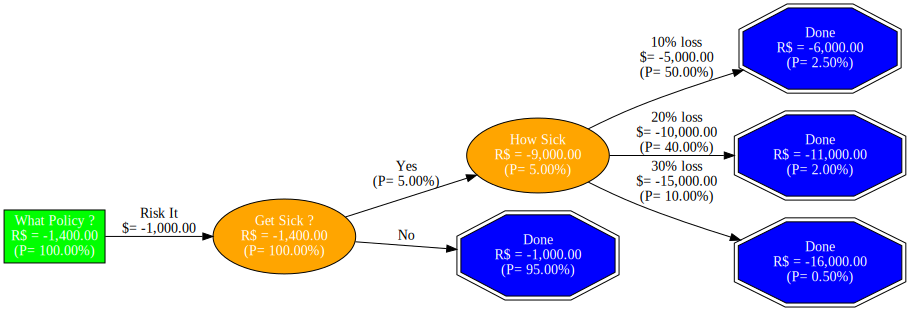

In [13]:
eng = GraphvizEngine(whatPolicy)
graph = eng.render("svg", True)

graphviz.Source(graph)

# Extracting Specific Values

For a specific decision node, a helper function will allow getting a list of alternatives, reduced payouts and margins to the chosen transition.

In [14]:
print("The best policy is {} with an expected cost of {:,.2f} $".format(
    whatPolicy.results.choice.name, -whatPolicy.results.strategicValue))

print()
print("Other Options:")

otherOptions = [t for t in whatPolicy.transitions 
                if t is not whatPolicy.results.choice]
otherOptions = sorted(otherOptions, 
                      key=lambda t: t.target.results.strategicValue, 
                      reverse=True)
for op in otherOptions:
    print("    {:12}: {:-,.2f} $ (margin: {:-,.2f} $)".format(
        op.name, -op.target.results.strategicValue,
        whatPolicy.results.strategicValue - op.target.results.strategicValue
    ))

The best policy is Risk It with an expected cost of 1,400.00 $

Other Options:
    Be Immortal : 1,525.00 $ (margin: 125.00 $)
    Nothing     : 1,600.00 $ (margin: 200.00 $)
    Stayin Alive: 2,000.00 $ (margin: 600.00 $)


## Outcomes and Probabilities (Distribution)

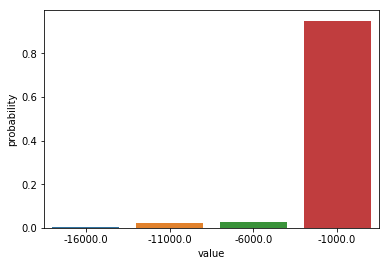

In [15]:
possiblilities = solver.payoutDistribution()
sb.barplot(possiblilities.index, "probability", data=possiblilities)

# Simulation for Different Probabilities of Being Sick (manually)

## Generating a Tree

This is a low processing example so I build a tree adapted to the parameters of every iteration.

Should the probel be bigger and performance matter, it would be faster to simply modify the probability of the target transitions and re-solve the tree. The easiest way to do that would be to keep a reference of these transitions as they are built, but it is also possible to "walk" the tree and locate them afterward.

As a note, I am re-coding a lot of things for the sake of this demonstration, but you might notice that the entire tree is built and solved as part of the following function.

In [16]:
strategy = createMaxExpected()

def resolveForSickProb(pSick):
    def fallingSick(policy):
        costFunction = policy[2]

        howSick = Event("Get Sick")

        for l, p in LEVELS_PROBS:
            cost = LIFE * l
            costAfterPolicy = costFunction(cost)
            howSick.transitions.append(
                Transition("{:.0%} loss".format(l), 
                           probability=p, payout=-costAfterPolicy))

        return Event("Get Sick ?", (
            Transition("Yes", probability=pSick, target=howSick),
            Transition("No")))

    whatPolicy = Decision("What Policy ?")
    for pol in POLICIES:
        name, cost, costFunction = pol
        whatPolicy.transitions.append(
            Transition(name, -cost, target=fallingSick(pol)))

    solver = Solver(whatPolicy, strategy)
    solver.solve()
    
    bestPolicy = whatPolicy.results.choice.name
    bestCost = whatPolicy.results.strategicValue
    costs= [t.target.results.strategicValue for t in whatPolicy.transitions]
    
    return (bestPolicy, bestCost, *costs)

## Evaluating for Probabilities between 0% and 100%

In [17]:
probs = np.linspace(0,1, 1000)
names = [t.name for t in whatPolicy.transitions]
df = pd.DataFrame([(p, *resolveForSickProb(p)) 
                   for p in probs], 
                  columns=("prob", "best", "cost", *names))
df.head(4)

,prob,best,cost,Stayin Alive,Be Immortal,Risk It,Nothing
0,0.000000,Nothing,0.000000,-2000.0,-1500.000000,-1000.000000,0.000000
1,0.001001,Nothing,-32.032032,-2000.0,-1500.500501,-1008.008008,-32.032032
2,0.002002,Nothing,-64.064064,-2000.0,-1501.001001,-1016.016016,-64.064064
3,0.003003,Nothing,-96.096096,-2000.0,-1501.501502,-1024.024024,-96.096096


## Visualizing the Costs for Different Probabilities

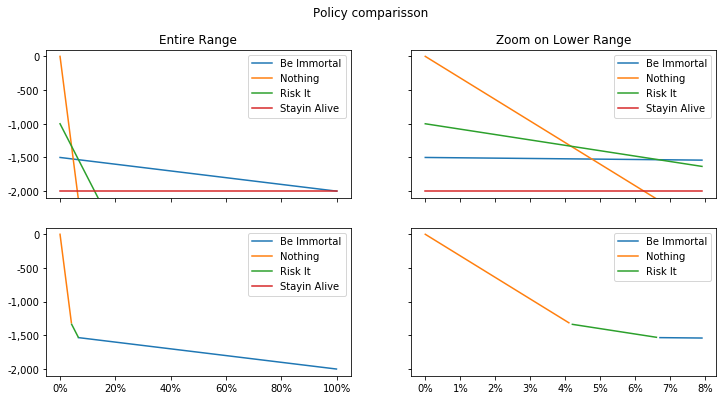

In [18]:
names = sorted(names)

df2 = df.drop("cost", axis=1)

fig, axs = plt.subplots(2,2, sharey=True, figsize=(12,6))
fig.suptitle("Policy comparisson")

def graphs(c, p, title):
    ax = axs[0][c]
    df2[df2.prob <= p].plot(x="prob", y=names, ylim=(-2100, 100), title=title,ax=ax)
    ax.xaxis.label.set(visible=False)
    ax.xaxis.set(ticklabels=[])
    ax.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))
    
    ax = axs[1][c]
    groups = {}
    for n,g in df[df.prob <= p].groupby("best"): groups[n] = g

    for n in names:
        if n in groups:
            g = groups[n]
            ax.plot(g.prob, g.cost, label=n)
    ax.xaxis.set_major_formatter(FuncFormatter("{:.0%}".format))
    ax.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))
    ax.legend()


graphs(0, 1, "Entire Range")
graphs(1, 0.08, "Zoom on Lower Range")


# Sensitivity Analysis (provided)

In [19]:
from pynetrees.sensitivity import SensitivityAnalysis, Variable, Output

solver = Solver(whatPolicy, createMaxExpected())

def setPSick(psick):
    for t in whatPolicy.transitions:
        t.target.transit("Yes").probability = psick

def setSA(cost):
    whatPolicy.transit("Stayin Alive").payout = cost
        
variables = [
    Variable("Probability of Getting Sick", setPSick, 0.05, np.linspace(.01,.1, 50)),
    Variable("Real Cost of Staying Alive", setSA, -2000, np.linspace(-1200,-2500, 50)),    
]
outputs = [
    Output("Strategy Value", lambda:whatPolicy.results.strategicValue),    
    Output("Best Strategy", lambda:whatPolicy.results.choice.name)
]

class PolicyGetter:
    def __init__(self, t):
        self.name = t.name
        self.t = t
        self.getter = self.doget

    def doget(self):
        return self.t.target.results.strategicValue
    
for t in whatPolicy.transitions:
    outputs.append(PolicyGetter(t))
    
    
sensitivityAnalysis = SensitivityAnalysis(solver, variables, outputs)

def title(msg):
    for i in range(4):
        print()
    print(msg)
        
title("Base Values")
display(sensitivityAnalysis.baseValues)

title("Extremums")
display(sensitivityAnalysis.extremums)


title("Individual Responses")
for name, ir in sensitivityAnalysis.individualResponses.items():
    title(name)
    display(ir)





Base Values


,base
Strategy Value,-1400
Best Strategy,Risk It
Stayin Alive,-2000
Be Immortal,-1525
Risk It,-1400
Nothing,-1600






Extremums


Strategy Value       Best Strategy                \
                                       Low  High           Low          High   
Probability of Getting Sick          -1550  -320   Be Immortal       Risk It   
Real Cost of Staying Alive           -1400 -1200       Risk It  Stayin Alive   

                            Stayin Alive       Be Immortal       Risk It  \
                                     Low  High         Low  High     Low   
Probability of Getting Sick        -2000 -2000       -1550 -1505   -1800   
Real Cost of Staying Alive         -2500 -1200       -1525 -1525   -1400   

                                  Nothing        
                             High     Low  High  
Probability of Getting Sick -1080   -3200  -320  
Real Cost of Staying Alive  -1400   -1600 -1600





Individual Responses




Probability of Getting Sick


,Probability of Getting Sick,Strategy Value,Best Strategy,Stayin Alive,Be Immortal,Risk It,Nothing
0,0.010000,-320.000000,Nothing,-2000.0,-1505.000000,-1080.000000,-320.000000
1,0.011837,-378.775510,Nothing,-2000.0,-1505.918367,-1094.693878,-378.775510
2,0.013673,-437.551020,Nothing,-2000.0,-1506.836735,-1109.387755,-437.551020
3,0.015510,-496.326531,Nothing,-2000.0,-1507.755102,-1124.081633,-496.326531
4,0.017347,-555.102041,Nothing,-2000.0,-1508.673469,-1138.775510,-555.102041
5,0.019184,-613.877551,Nothing,-2000.0,-1509.591837,-1153.469388,-613.877551
6,0.021020,-672.653061,Nothing,-2000.0,-1510.510204,-1168.163265,-672.653061
7,0.022857,-731.428571,Nothing,-2000.0,-1511.428571,-1182.857143,-731.428571
8,0.024694,-790.204082,Nothing,-2000.0,-1512.346939,-1197.551020,-790.204082
9,0.026531,-848.979592,Nothing,-2000.0,-1513.265306,-1212.244898,-848.979592






Real Cost of Staying Alive


,Real Cost of Staying Alive,Strategy Value,Best Strategy,Stayin Alive,Be Immortal,Risk It,Nothing
0,-1200.000000,-1200.000000,Stayin Alive,-1200.000000,-1525.0,-1400.0,-1600.0
1,-1226.530612,-1226.530612,Stayin Alive,-1226.530612,-1525.0,-1400.0,-1600.0
2,-1253.061224,-1253.061224,Stayin Alive,-1253.061224,-1525.0,-1400.0,-1600.0
3,-1279.591837,-1279.591837,Stayin Alive,-1279.591837,-1525.0,-1400.0,-1600.0
4,-1306.122449,-1306.122449,Stayin Alive,-1306.122449,-1525.0,-1400.0,-1600.0
5,-1332.653061,-1332.653061,Stayin Alive,-1332.653061,-1525.0,-1400.0,-1600.0
6,-1359.183673,-1359.183673,Stayin Alive,-1359.183673,-1525.0,-1400.0,-1600.0
7,-1385.714286,-1385.714286,Stayin Alive,-1385.714286,-1525.0,-1400.0,-1600.0
8,-1412.244898,-1400.000000,Risk It,-1412.244898,-1525.0,-1400.0,-1600.0
9,-1438.775510,-1400.000000,Risk It,-1438.775510,-1525.0,-1400.0,-1600.0


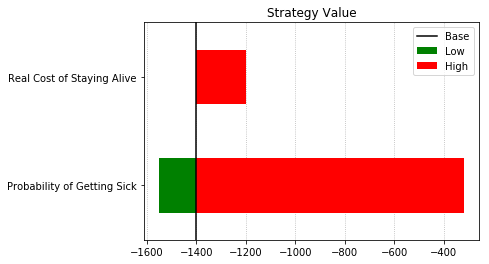

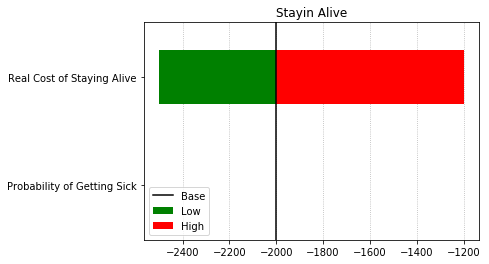

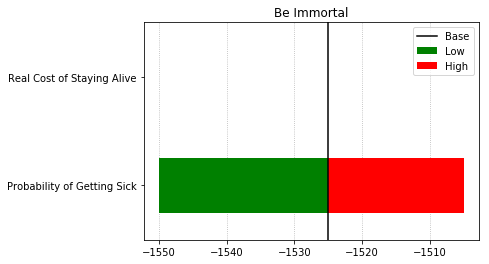

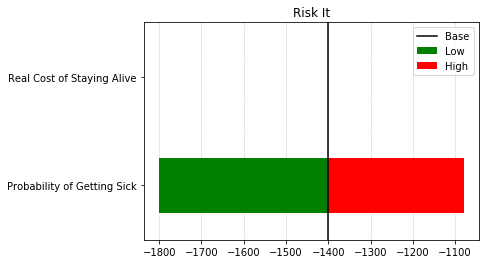

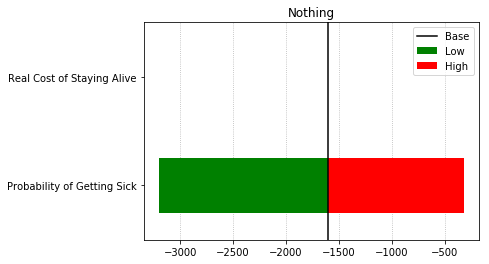

In [20]:
igs = sensitivityAnalysis.getImpactGraphs(invertColors=True)

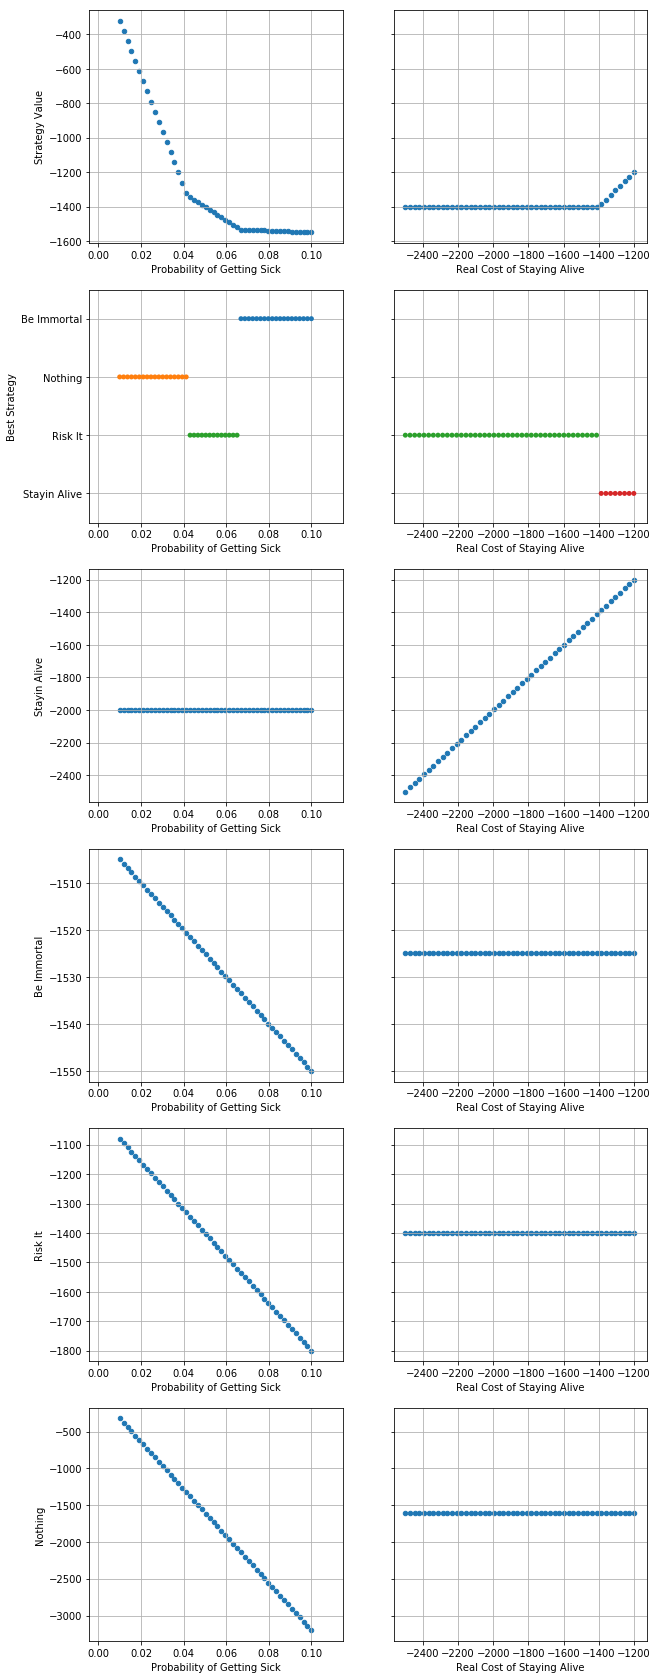

In [21]:
d = sensitivityAnalysis.getIndivisualResponseGraphs(hideExtraYLabels=True)

In [22]:
reversed([1,2])